``` 
Ideas

1. Convert numerical features to categorical features by using np.round(df[cont_features], decimals=1)
2. Then run different models to see the performance.
```

```
Remarks

1. Addition of features does not offer any improvements in the score.
2. Not able to beat random forest benchmark score ( I think it is because of the number of trees used by myself )
```

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import os,sys

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

basepath = os.path.expanduser('~/Desktop/src/AllState_Claims_Severity/')
sys.path.append(os.path.join(basepath, 'src'))

np.random.seed(2016)

from data import *

In [2]:
# load files
train      = pd.read_csv(os.path.join(basepath, 'data/raw/train.csv'))
test       = pd.read_csv(os.path.join(basepath, 'data/raw/test.csv'))
sample_sub = pd.read_csv(os.path.join(basepath, 'data/raw/sample_submission.csv'))

In [3]:
cont_features = [col for col in train.columns[1:-1] if 'cont' in col] # this could probably be shifted to common utility
cat_features  = [col for col in train.columns[1:-1] if 'cat' in col]  

In [4]:
# create an indicator for somewhat precarious values for loss. ( only to reduce the number of training examples. )
train['loss_indicator'] = train.loss.map(lambda x: int(x < 4e3))

In [5]:
# create a stratified sample

skf = StratifiedKFold(train.loss_indicator, n_folds=2, shuffle=True, random_state=111)
itrain, itest = next(iter(skf))

train_ = train.iloc[itrain]

In [7]:
train_cont           = np.round(train_[cont_features], decimals=1)
test_cont            = np.round(test[cont_features], decimals=1)

train_cat, test_cat  = encode_categorical_features(train_[cat_features], test[cat_features])

** Features **

* Roundoff cont2 variable to single decimal
* Create another categorical feature marking whether cont2_rounded is equal to .6 or not
* For cont7 flag for 0.0 and 1.0 as loss values are different.

In [26]:
# X = train_cont[['cont2', 'cont3', 'cont7', 'cont11', 'cont13']]
X = pd.concat((train_cont, train_cat), axis=1)
y = (train_.loss) # take into log space

In [11]:
test_processed = pd.concat((test_cont, test_cat), axis=1)

** Split into training and test sets **

In [27]:
itrain, itest = train_test_split(range(len(X)), stratify=train_.loss_indicator, test_size=0.2, random_state=123)

In [28]:
X_train = X.iloc[itrain]
X_test  = X.iloc[itest]

y_train = y.iloc[itrain]
y_test  = y.iloc[itest]

** Set up a cross validation scheme **

* Needs loss indicator to set up stratified sample splits.
* feature matrix and target array.
* Estimator to fit on the data.
* Returns the list of mean absolute errors obtained on each cross validation fold.

In [29]:
def get_cv_scores(train_sub, X_train, y_train, n_estimators=10):
    
    skf = StratifiedKFold(train_sub.loss_indicator, n_folds=3, shuffle=True, random_state=112)
    scores = []

    for itr, ite in skf:
        X_tr = X_train.iloc[itr]
        X_te = X_train.iloc[ite]

        y_tr = y_train.iloc[itr]
        y_te = y_train.iloc[ite]

        est1 = RandomForestRegressor(n_estimators=n_estimators, max_depth=15, n_jobs=-1, random_state=1222)
        est2 = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=15, n_jobs=-1, random_state=2324)
    
        est1.fit(X_tr, y_tr)
        est2.fit(X_tr, y_tr)

        y_pred1  = (est1.predict(X_te))
        y_pred2  = (est2.predict(X_te))

        y_pred = 0.5 * y_pred1 + 0.5 * y_pred2

        scores.append(mean_absolute_error(y_te, y_pred))
    return scores

In [30]:
scores = get_cv_scores(train_.iloc[itrain], X_train, y_train)

In [31]:
print('Scores for every fold during cross validation ', scores)

Scores for every fold during cross validation  [1357.3898016931937, 1363.9219379602066, 1358.8900116382165]


In [37]:
# est = Lasso()
est1 = RandomForestRegressor(max_depth=7, n_jobs=-1, random_state=12442)
est2 = ExtraTreesRegressor(max_depth=7, n_jobs=-1, random_state=23141)

# retrain the model
est1.fit(X_train, y_train)
est2.fit(X_train, y_train)

y_pred1  = (est1.predict(X_test))
y_pred2  = (est2.predict(X_test))
    
y_pred = 0.5 * y_pred1 + 0.5 * y_pred2

In [38]:
print('Mean Absolute Error on unseen examples ', mean_absolute_error(y_test, y_pred))

Mean Absolute Error on unseen examples  1361.93783826


** Lets see if number of estimators has an effect on the overall performance or not. **

In [39]:
def perf_by_estimators(train_sub, X_train, y_train, estimators=[10, 25, 50, 75]):
    mean_cv_scores = []
    for estimator in estimators:
        scores = get_cv_scores(train_sub, X_train, y_train, n_estimators=estimator)
        mean_cv_scores.append(np.mean(scores))
    
    plt.scatter(estimators, mean_cv_scores)
    plt.xlabel('Number of Trees')
    plt.ylabel('MAE score')
    return mean_cv_scores

[1361.4373122208128,
 1359.9628944698882,
 1359.5855976242822,
 1359.0492117847646]

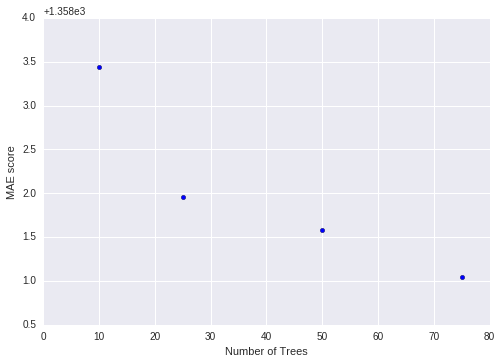

In [40]:
perf_by_estimators(train.iloc[itrain], X_train, y_train)